In [2]:
import numpy as np
from numpy import genfromtxt
from trueskill import TrueSkill, Rating, quality_1vs1, rate_1vs1
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
from matplotlib import cm
from scipy import stats
import operator as op
import pandas as pd
from ast import literal_eval
from mpl_toolkits.mplot3d import Axes3D
import math
import sys

# Rastrigin function
## Optimization Methods
---
https://www.sfu.ca/~ssurjano/rastr.html

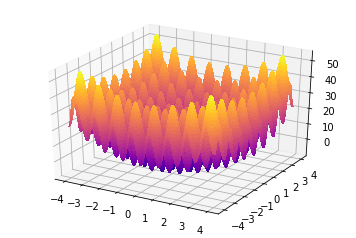

In [3]:
def rastrigin(*X, **kwargs):
    A = kwargs.get('A', 10)
    return A + sum([(x**2 - A * np.cos(2 * math.pi * x)) for x in X])

if __name__ == '__main__':
    X = np.linspace(-4, 4, 200)    
    Y = np.linspace(-4, 4, 200)    

    X, Y = np.meshgrid(X, Y)

    Z = rastrigin(X, Y, A=10)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.plasma, linewidth=0, antialiased=False)    
    plt.savefig('rastrigin', format='pdf')

## Simulated Annealing
---
### Cooling Schedule

Now we must define the functions that constitute our cooling schedule. We reduce the temperature by a multiplicative factor of 0.8, and increase the epoch length by a factor of 1.2

### Running the Algorithm

We define the `sa` function that takes a set of initial conditions, on temperature, length of epoch, and starting point, the energy function, the number or opochs to run, the cooling schedule, and the proposal, and implements the algorithm defined above. Our algorithms structure is that of running for some epochs during which we reduce the temperature and increase the epoch iteration length. This is somewhat wasteful, but simpler to code, although it is not too complex to build in stopping conditions.

In [529]:
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc,sigma = 0.75,x1 = 20,x0 = 0.5,alpha = -1.5):
    # out plot
    OUT_List_Simanneal = []
    Iterations = []
    
    accumulator=[]
    best_solution = old_solution = initials['solution']
    T=initials['T']
    length=initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted=0
    total=0
    
    best_index=total
    best_temp=T
    
    
    for index in range(epochs):
        # print("Epoch", index)
        if index > 0:
            T = tempfunc(T)
            length=iterfunc(length)
            sys.stdout.write("\r Temperature " + str(T))
            sys.stdout.flush()
        # print("Temperature", T, "Length", length)
        for it in range(length):
            Iterations.append(total)
            OUT_List_Simanneal.append(old_energy)
            total+=1
            new_solution = np.copy(old_solution)
            for y in new_solution:
                if proposalfunc == 'rdmGauss':
                    y[0] = y[0] + rdmGauss(sigma = sigma)
                else:
                    y[0] = y[0] + rdmSimetricPoerLow(x1 = x1, x0 = x0, alpha = alpha)
                if y[0] < -5.12 :
                    y[0] = -5.12
                elif y[0] > 5.12:
                    y[0] = 5.12
                    
            # new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            # Use a min here as you could get a "probability" > 1
            alphaLoc = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alphaLoc)):
                # Accept proposed solution
                accepted+=1
                accumulator.append((T, new_solution, new_energy))
                #OUT_List_Simanneal.append(new_energy)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index=total
                    best_temp=T
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
                #OUT_List_Simanneal.append(old_energy)
    
    best_meta=dict(index=best_index, temp=best_temp)
    # print("frac accepted", accepted/total, "total iterations", total, 'bmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator, OUT_List_Simanneal, Iterations

In [291]:
# http://mathworld.wolfram.com/RandomNumber.html
# https://stackoverflow.com/questions/918736/random-number-generator-that-produces-a-power-law-distribution
def rdmSimetricPoerLow(x1 = 20, x0 = 0.5, alpha = -1.5):
    y = np.random.uniform(0,1,1)
    x = math.pow((math.pow(x1, (alpha + 1)) - math.pow(x0, (alpha + 1)))*y + math.pow(x0, (alpha + 1)),(1/(alpha+1)))
    sign = np.random.uniform(0,1,1)
    return x if sign > 0.5 else -x

In [464]:
def rdmGauss(sigma = 0.2, mu = 0):
    return np.random.normal(mu, sigma, 1)

In [293]:
def Rastrigin(fevalMtx, A = 10):
    return A * fevalMtx.shape[0] + sum([(x[0]**2 - A * np.cos(2 * math.pi * x[0])) for x in fevalMtx])



In [294]:
def RastriginGradient(fevalMtx, A = 10):
    delta = np.zeros((fevalMtx.shape[0], 1))
    for i in range(fevalMtx.shape[0]):
        delta[i][0] = (fevalMtx[i][0] * 2) + (A * 2 * math.pi * np.sin(2 * math.pi * fevalMtx[i][0]))
   
    return delta

In [295]:
def min_RastriginPowerLaw(fevalMtx, x1, x0, alpha):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmSimetricPoerLow(x1 = x1, x0 = x0, alpha = alpha)
        
        if y[0] < -5.12 :
            y[0] = -5.12
        elif y[0] > 5.12:
            y[0] = 5.12
    
    prev = Rastrigin(fevalMtx);
    new = Rastrigin(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx
            

In [296]:
def min_RastriginHill(fevalMtx,sigma):
    Y = np.copy(fevalMtx)
    for y in Y:
        y[0] = y[0] + rdmGauss(sigma)
        
        if y[0] < -5.12 :
            y[0] = -5.12
        elif y[0] > 5.12:
            y[0] = 5.12
    
    prev = Rastrigin(fevalMtx);
    new = Rastrigin(Y);
    
    if new <= prev:
        return new, Y
    else:
        return prev, fevalMtx

In [297]:
def min_RastriginGradiente(fevalMtx, delta, alpha = 0.0001, miu = 0.7):
    alpha = alpha;
    miu = miu;
    grad = RastriginGradient(fevalMtx)
    Y = np.copy(fevalMtx)
    for i in range(fevalMtx.shape[0]):
        delta[i][0] =  miu * delta[i][0] - grad[i][0] * alpha
        Y[i][0] = Y[i][0] + delta[i][0]
        
        if Y[i][0] < -5.12 :
            Y[i][0] = -5.12
        elif Y[i][0] > 5.12:
            Y[i][0] = 5.12
    
    
    new = Rastrigin(Y);
    
    return new, Y, delta 

# min_RastriginPowerLaw
## 2D

 Iteration 29

mean: 1.566699300966051
std: 0.6236977751355816
median: 1.4544754806022553
min: 0.4434486331631753
max: 2.903546828205087


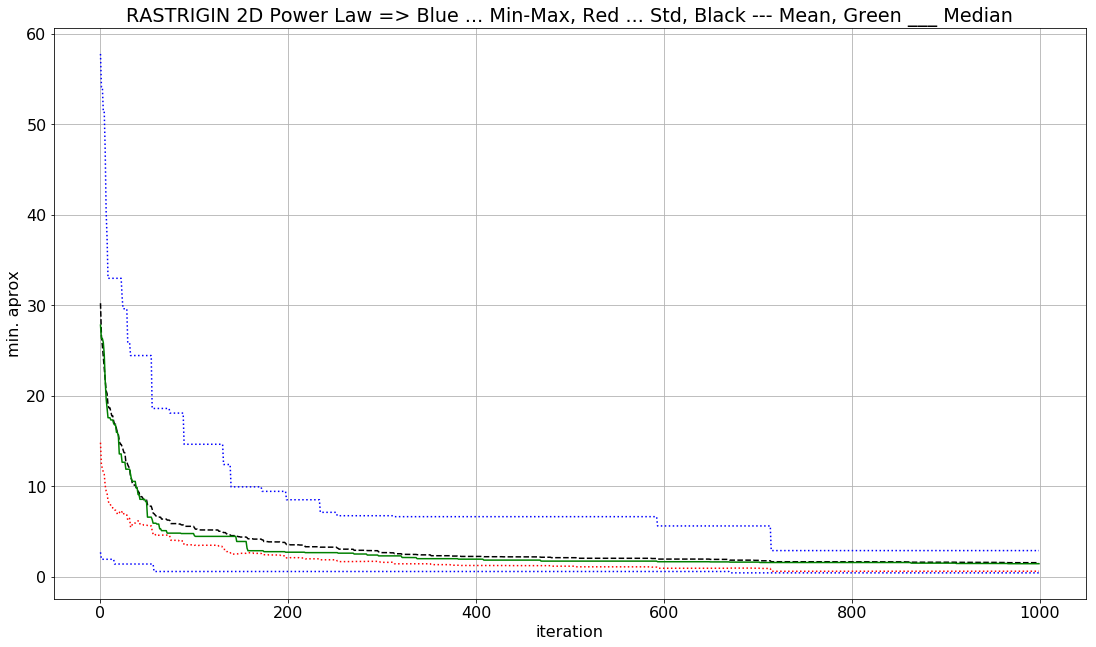

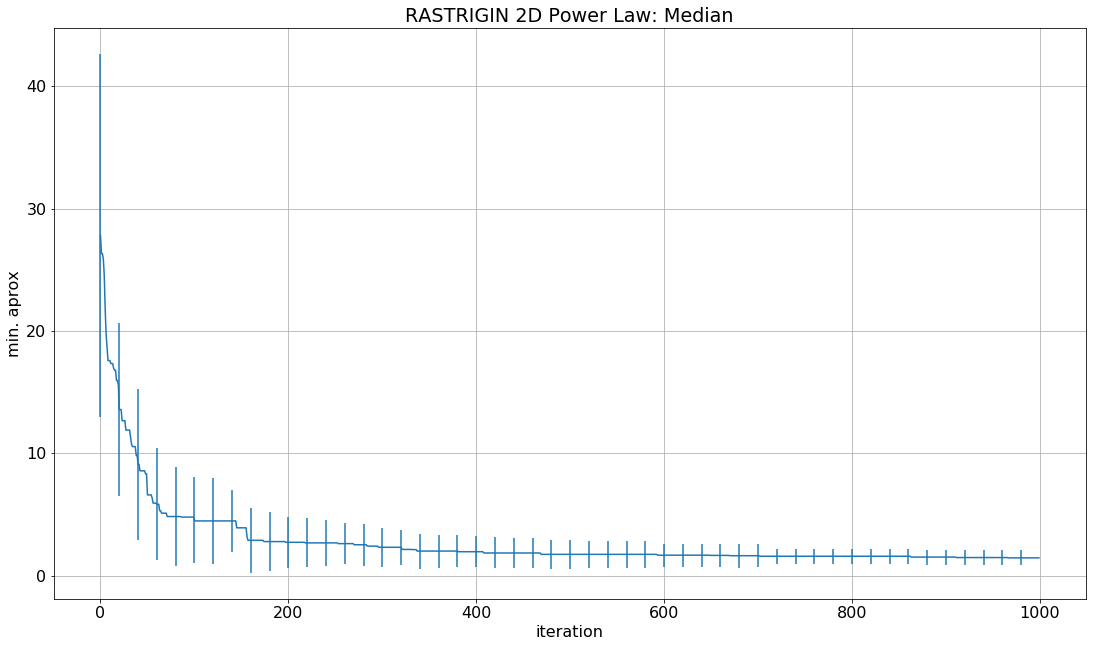

In [217]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_RastriginPowerLaw(fevalRdm, x1 = 20, x0 = 0.5, alpha = -1.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginPowerLaw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Power Law: Median")
plt.grid()
plt.savefig('rastriginPowerLawStd_2d.pdf', format='pdf')
plt.show()

## 10D

 Iteration 29

mean: 0.5992232788706303
std: 0.6551479843622697
median: 0.2515158011105214
min: 0.007942583695623284
max: 2.0183007833359454


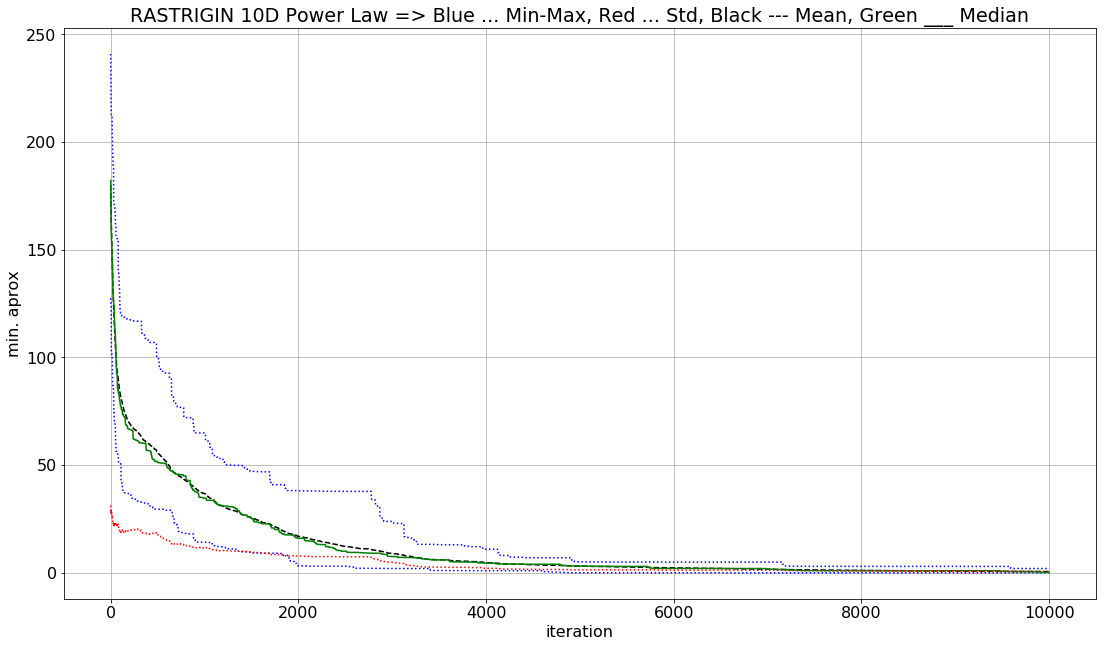

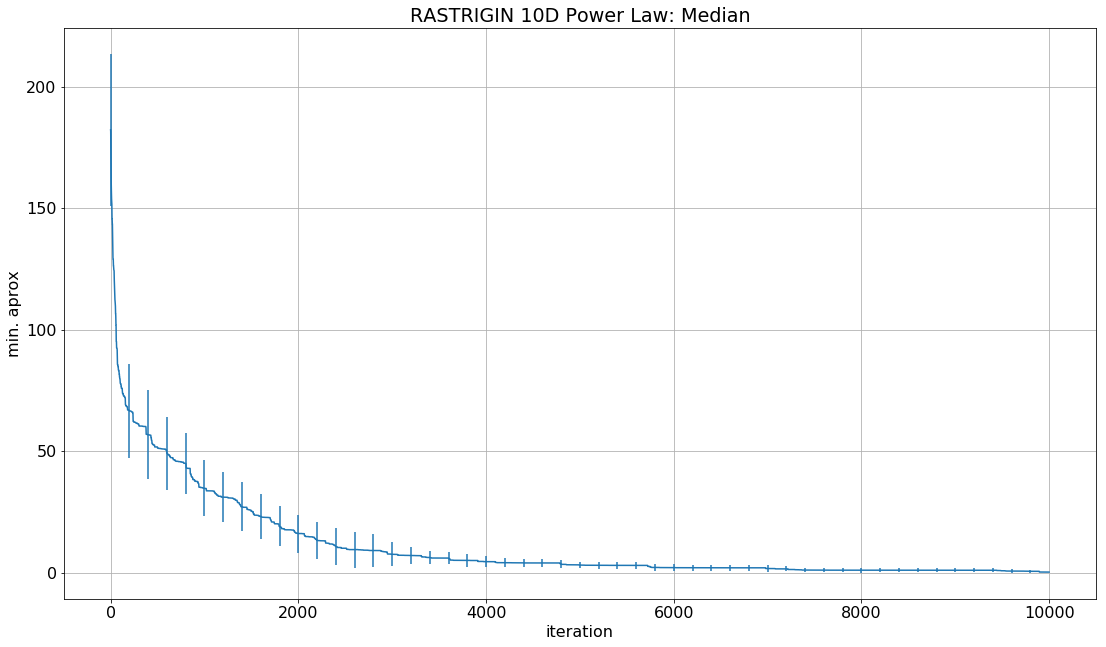

In [218]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions =30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_RastriginPowerLaw(fevalRdm, x1 =1.5, x0 = 0.001, alpha = -1.5)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Power Law => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginPowerLaw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Power Law: Median")
plt.grid()
plt.savefig('rastriginPowerLawStd_10d.pdf', format='pdf')
plt.show()

# min_Rastrigin Hill Climbing
## 2D

 Iteration 29

mean: 0.32807782180348644
std: 0.37944929145241674
median: 0.15646528448692898
min: 0.0010248889443182918
max: 1.27096238717548


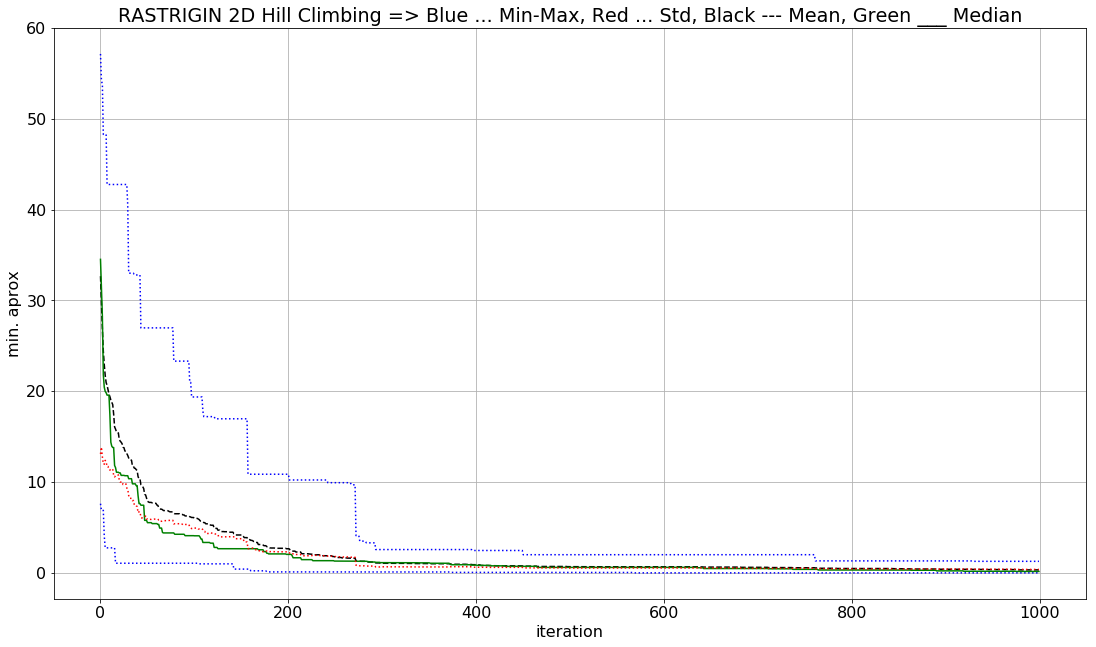

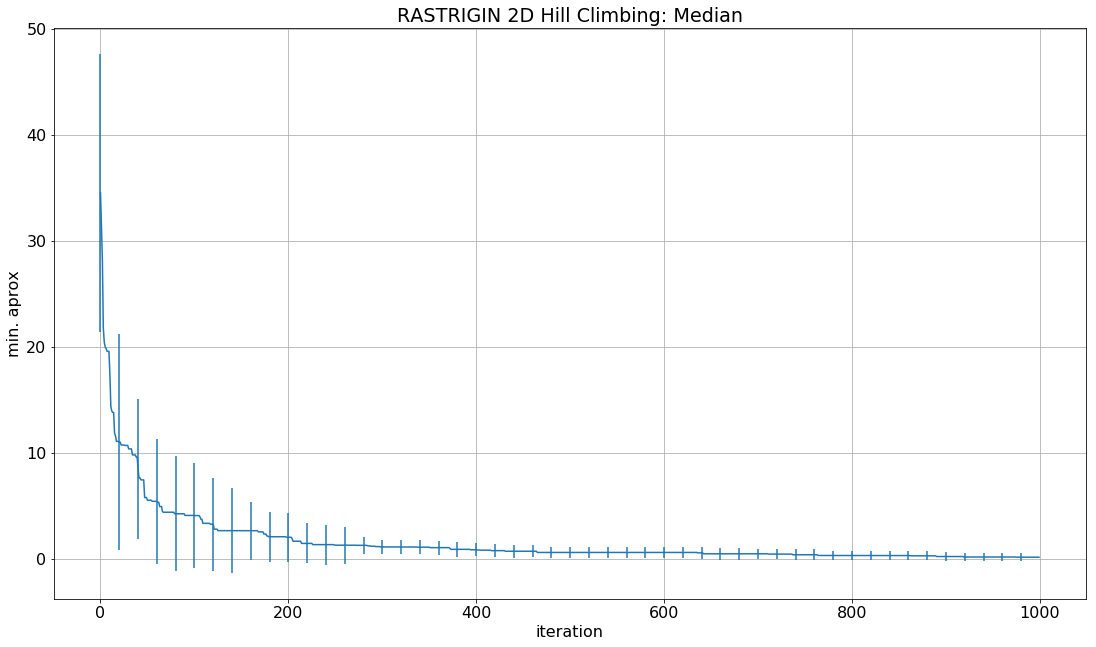

In [221]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_RastriginHill(fevalRdm, sigma = 0.7)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginHillClimbing_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Hill Climbing: Median")
plt.grid()
plt.savefig('rastriginHillClimbingStd_2d.pdf', format='pdf')
plt.show()

## 10D

 Iteration 29

mean: 42.91171962851197
std: 9.619292335677883
median: 41.46471487466556
min: 25.2910279504802
max: 66.66972226376052


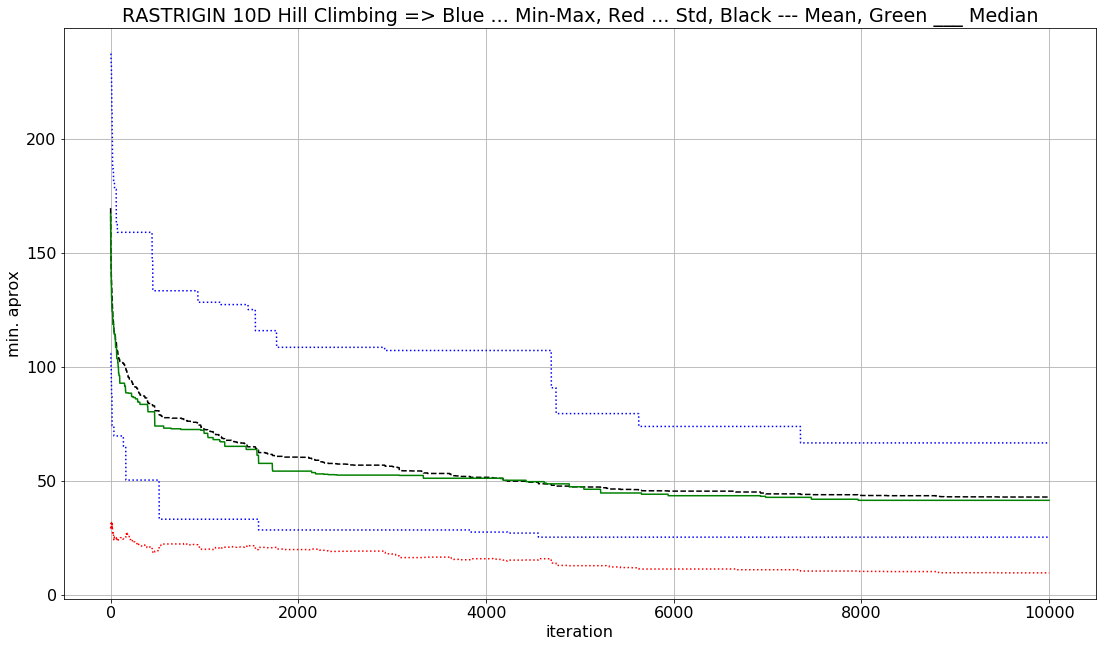

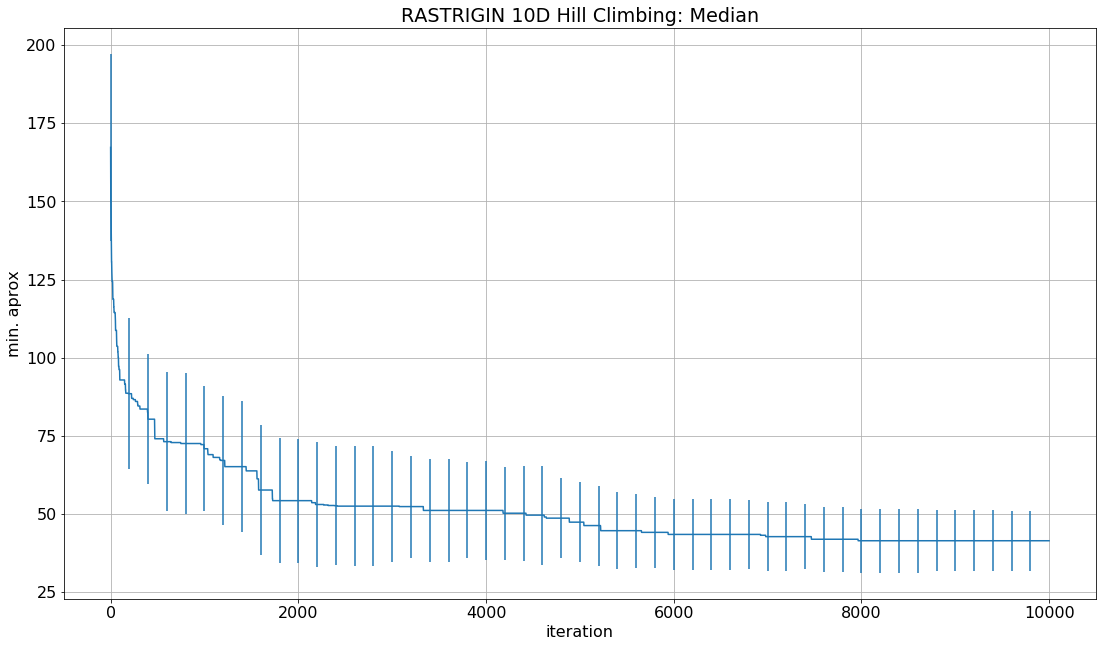

In [239]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm = min_RastriginHill(fevalRdm, sigma = 0.75)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Hill Climbing => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginHillClimbing_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Hill Climbing: Median")
plt.grid()
plt.savefig('rastriginHillClimbingStd_10d.pdf', format='pdf')
plt.show()

# Gradiente
## 2D

 Iteration 29

mean: 14.957456310680305
std: 10.502828974022037
median: 12.934432432041099
min: 0.9949590570932898
max: 40.79296672700376


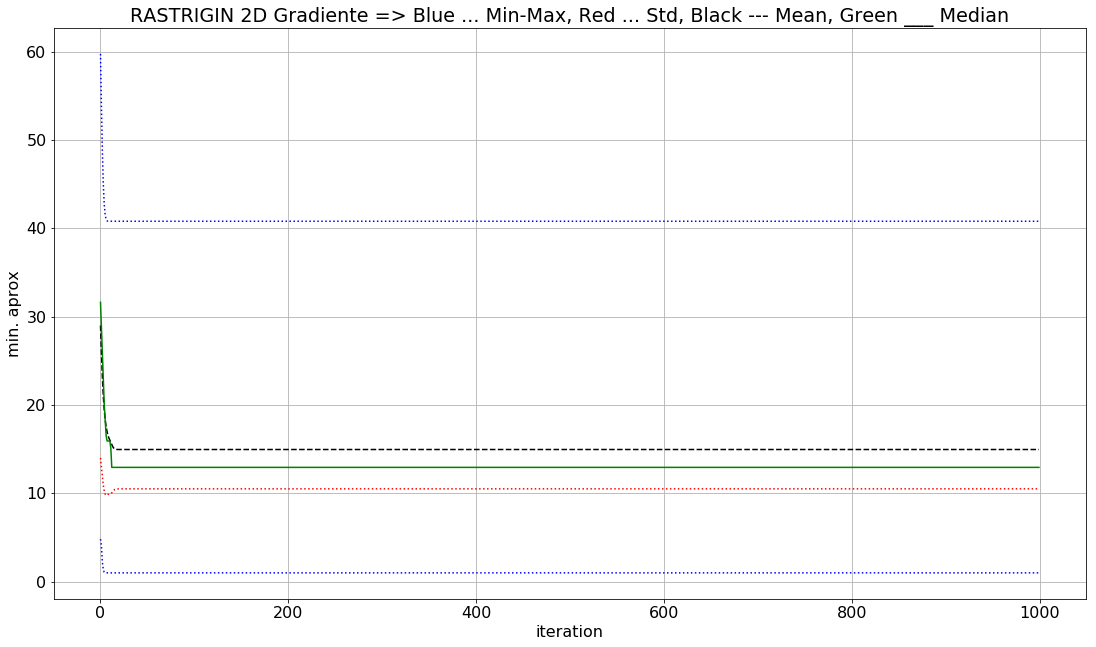

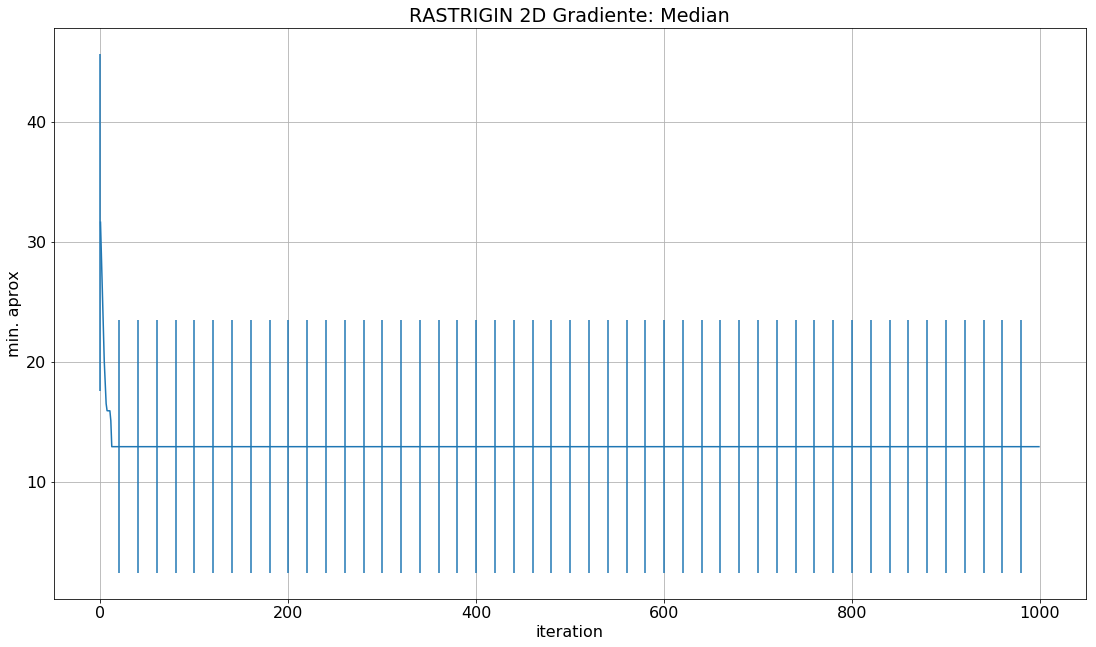

In [507]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_RastriginGradiente(fevalRdm,delta,alpha = 0.0007, miu = 0.3)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginGradiente_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Gradiente: Median")
plt.grid()
plt.savefig('rastriginGradienteStd_2d.pdf', format='pdf')
plt.show()

 Iteration 29

mean: 88.02015784089559
std: 21.767552638046354
median: 83.57609800925349
min: 52.732628012217326
max: 131.33364371861907


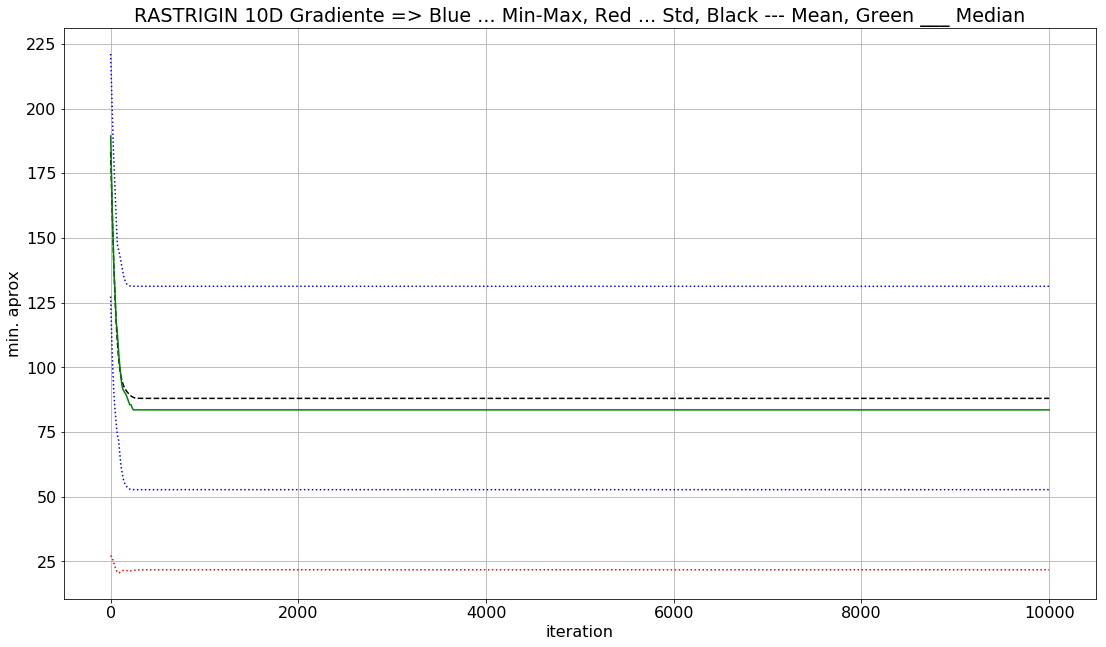

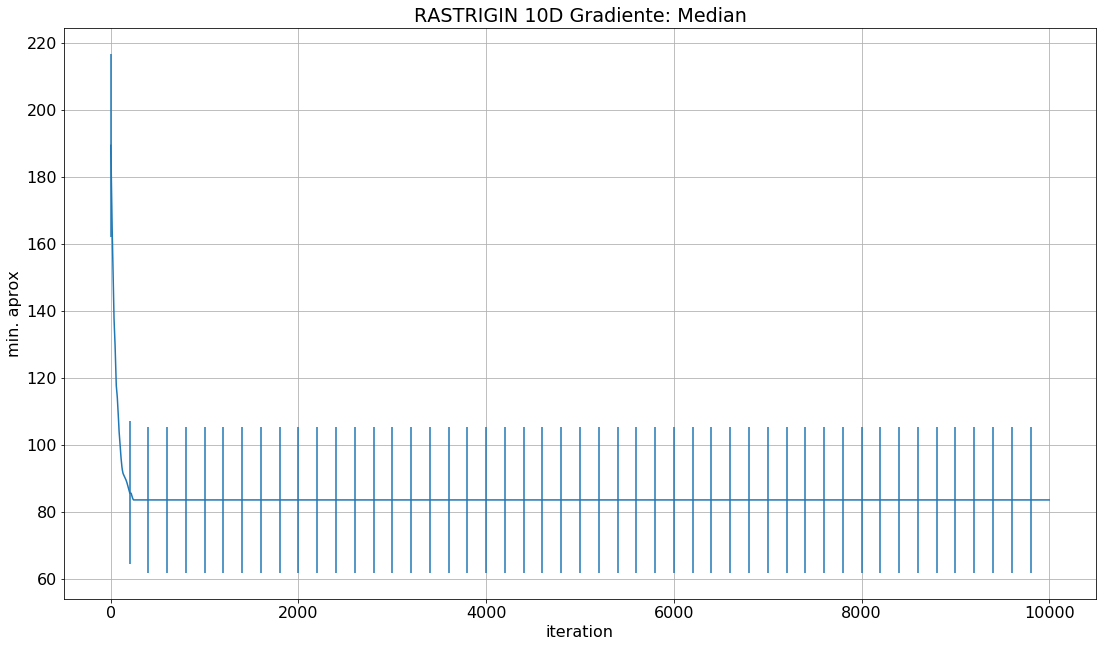

In [509]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = np.zeros((repetitions, iterSize))

    
for j in range(0, repetitions):
    Iterations = []
    
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    delta = np.zeros((valVectorSize, 1))
    sys.stdout.write("\r Iteration " + str(j))
    sys.stdout.flush()
    for i in range(0, iterSize):
        OUT, fevalRdm, delta = min_RastriginGradiente(fevalRdm,delta,alpha = 0.00007, miu = 0.0007)
        OUT_Matrix[j][i] = OUT
        Iterations.append(i)
    
    Best_List.append(OUT)
    
    
print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))



# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Gradiente => Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginGradiente_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Gradiente: Median")
plt.grid()
plt.savefig('rastriginGradienteStd_10d.pdf', format='pdf')
plt.show()

# Simulated annealing + Power Law
## 2D

 Temperature 0.9882515999999995

mean: 1.5865348309919272
std: 0.7895390356578746
median: 1.5499628676446342
min: 0.025982071280342467
max: 3.1517329573653896


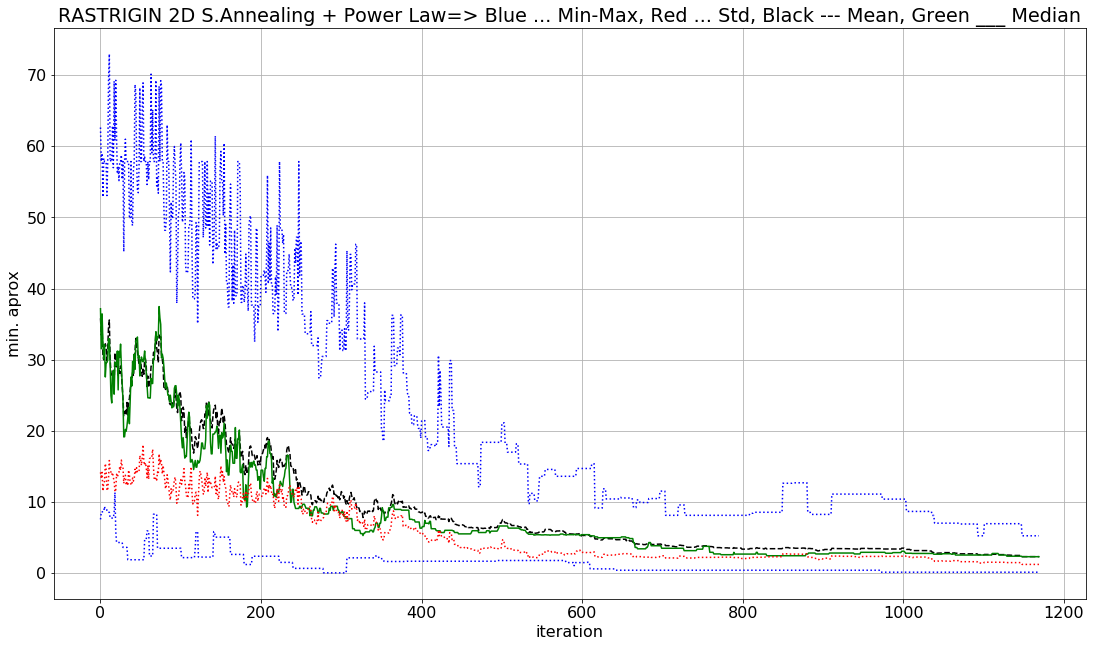

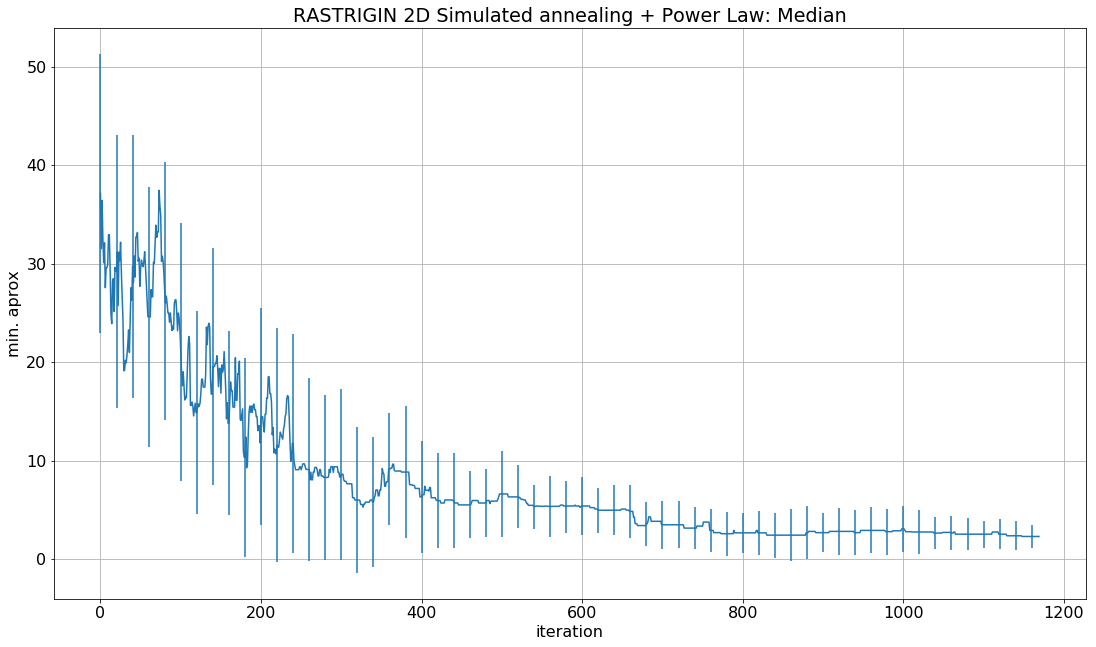

In [530]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=12)
    OUT_List_Simanneal_Tmp = []
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Rastrigin,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginSAnnealPlw_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('rastriginSAnnealPlwStd_2d.pdf', format='pdf')
plt.show()




## 10D

 Temperature 0.36028797018964004

mean: 2.0971141915419595
std: 1.3781285387423332
median: 1.9718184166874764
min: 0.1631396140300012
max: 6.173878535252143


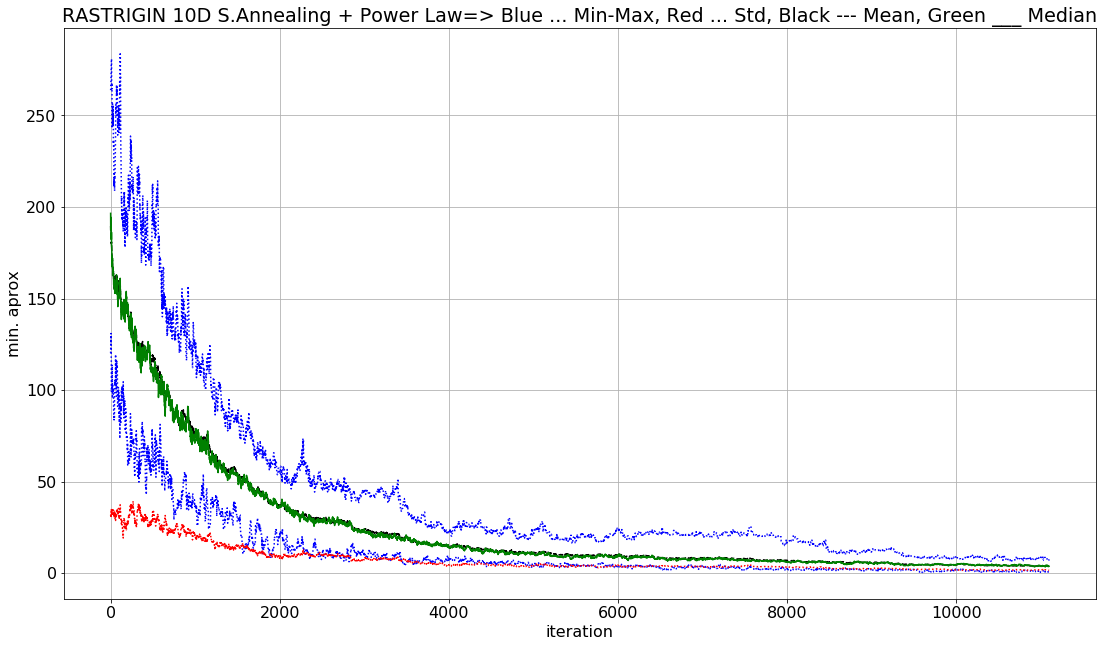

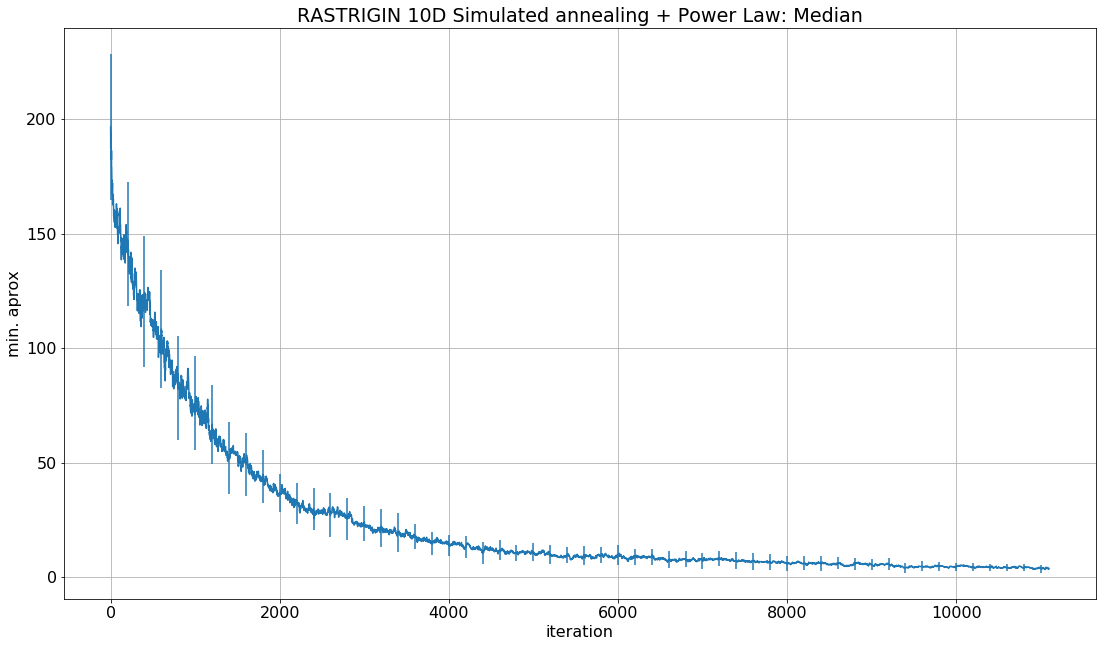

In [531]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=20)
    
    bmeta, bs, be, out, OUT_List_Simanneal10, Iterations = sa(Rastrigin,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmSimetricPoerLow',
                                                                sigma = 0.75,
                                                                x1 = 1,
                                                                x0 = 0.001,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal10).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal10).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D S.Annealing + Power Law=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginSAnnealPlw_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Simulated annealing + Power Law: Median")
plt.grid()
plt.savefig('rastriginSAnnealPlwStd_10d.pdf', format='pdf')
plt.show()





# Simulated annealing + Normal
## 2D

 Temperature 0.9882515999999995

mean: 0.557506515964177
std: 0.47685205557975097
median: 0.47592598140241726
min: 0.027561217297090934
max: 2.158607807909057


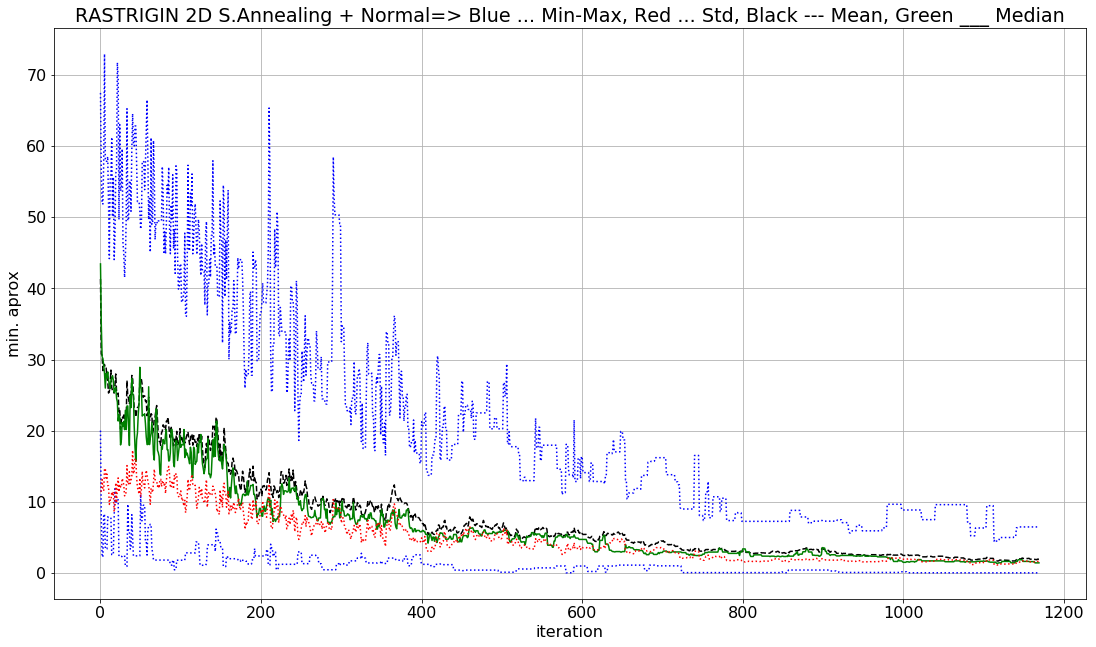

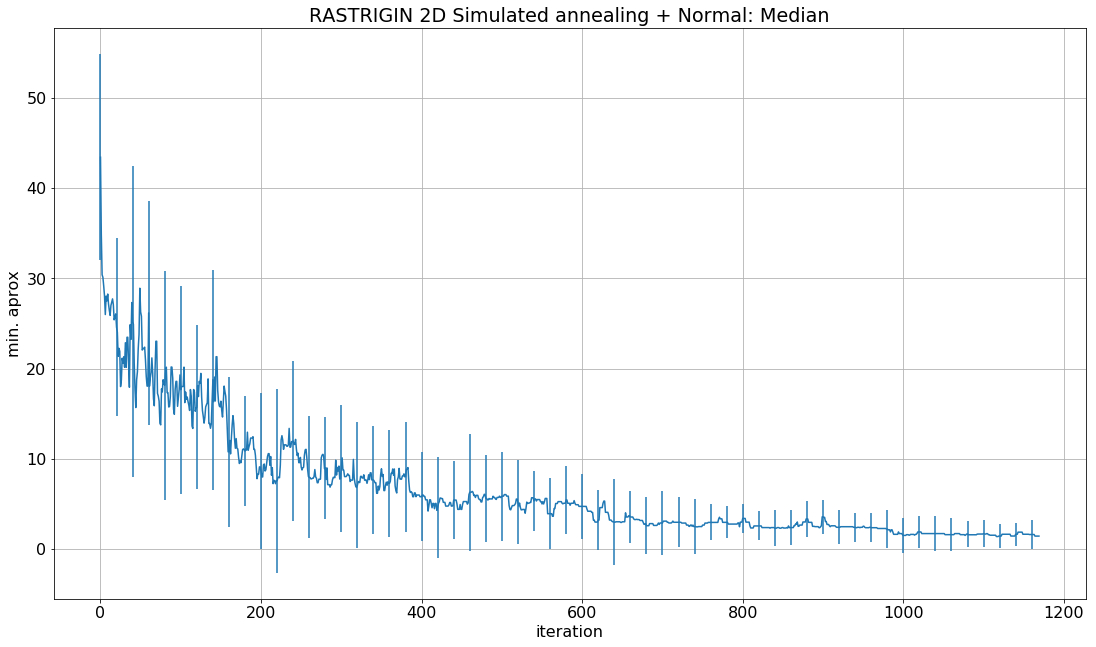

In [462]:
Best_List = []
valVectorSize = 2

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.7*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=12)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Rastrigin,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 0.75,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginSAnnealNrm_2d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:20] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 2D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('rastriginSAnnealNrmStd_2d.pdf', format='pdf')
plt.show()





## 10D

 Temperature 0.6124895493223881

mean: 48.4142082946101
std: 14.613870310274923
median: 47.129546452816236
min: 17.24396205960973
max: 78.40666715580669


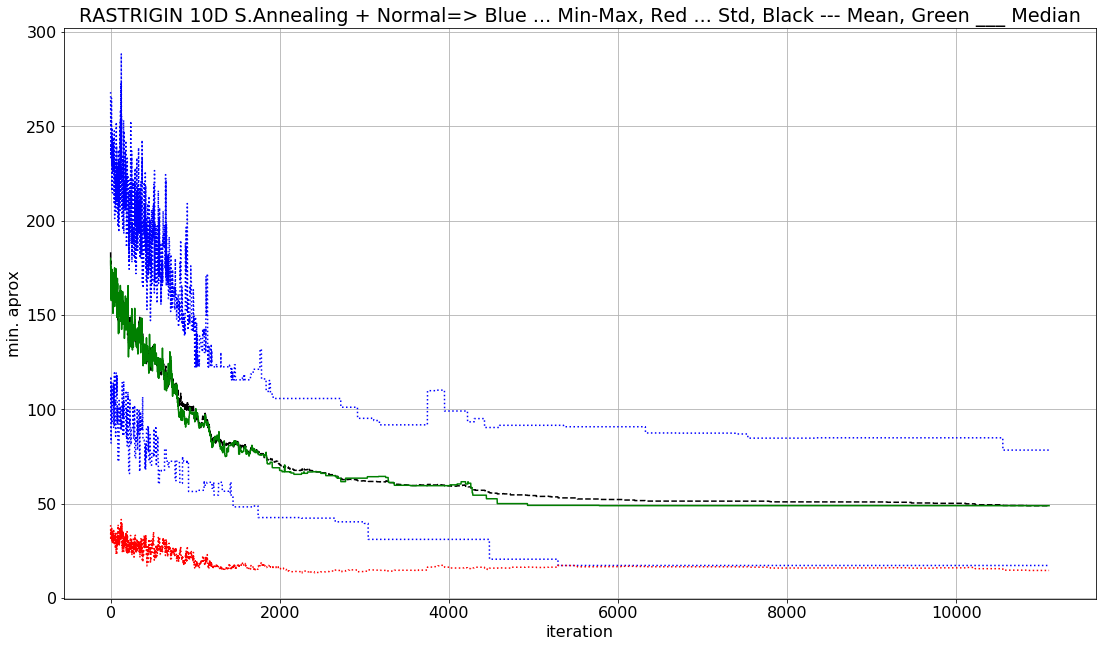

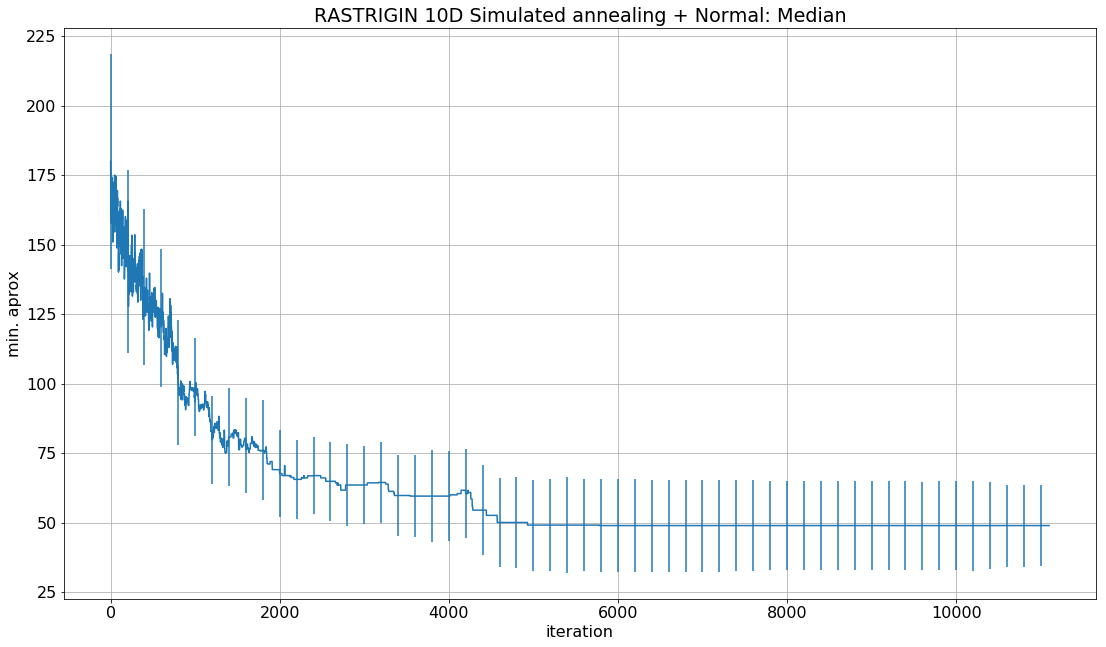

In [528]:
Best_List = []
valVectorSize = 10

if valVectorSize == 2:
    iterSize = 1000
    SimannealItrSize = 8
else:
    iterSize = 10000
    SimannealItrSize = 19
    
repetitions = 30
OUT_Matrix = None
OutIniFlag = False

tf = lambda t: 0.8*t #temperature function
itf = lambda length: math.ceil(1.2*length) #iteration function

for j in range(0, repetitions):
    fevalRdm =  np.random.uniform(low=-5, high=5, size=(valVectorSize, 1))
    inits=dict(solution=fevalRdm, length=70, T=34)
    
    bmeta, bs, be, out, OUT_List_Simanneal, Iterations = sa(Rastrigin,
                                                                inits,
                                                                SimannealItrSize,
                                                                tf,
                                                                itf,
                                                                'rdmGauss',
                                                                sigma = 0.42345,
                                                                x1 = 20,
                                                                x0 = 0.5,
                                                                alpha = -1.5)
    
    
    Best_List.append(be)
    if OutIniFlag == False:
        OutIniFlag = True
        OUT_Matrix = np.asarray(OUT_List_Simanneal).reshape(1,-1)
    else:
        OUT_Matrix = np.concatenate((OUT_Matrix, np.asarray(OUT_List_Simanneal).reshape(1,-1)), axis=0)



print('\n')
print('mean: ' + str(np.mean(Best_List)))
print('std: ' + str(np.std(Best_List)))
print('median: ' + str(np.median(Best_List)))
print('min: ' + str(np.amin(Best_List)))
print('max: ' + str(np.amax(Best_List)))


# multy curve plot
plt.rcParams.update({'font.size': 16})
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(np.squeeze(Iterations),
         np.squeeze(np.amax(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.amin(OUT_Matrix, axis=0)),
         'b:',
         np.squeeze(Iterations),
         np.squeeze(np.mean(OUT_Matrix, axis=0)),
         'k--',
         np.squeeze(Iterations),
         np.squeeze(np.median(OUT_Matrix, axis=0)),
         'g-',
         np.squeeze(Iterations),
         np.squeeze(np.std(OUT_Matrix, axis=0)),
         'r:',)


plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D S.Annealing + Normal=> Blue ... Min-Max, Red ... Std, Black --- Mean, Green ___ Median")
plt.grid()
plt.savefig('rastriginSAnnealNrm_10d.pdf', format='pdf')
plt.show()


# Standard Deviation Plot
Ala = np.std(OUT_Matrix, axis=0)
stdBarIndex = np.zeros((Ala.shape[0]))
stdBarIndex[0:Ala.shape[0]:200] = 1
truncated = Ala*stdBarIndex
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.errorbar(Iterations, np.median(OUT_Matrix, axis=0), truncated)
plt.ylabel('min. aprox')
plt.xlabel('iteration')
plt.title("RASTRIGIN 10D Simulated annealing + Normal: Median")
plt.grid()
plt.savefig('rastriginSAnnealNrmStd_10d.pdf', format='pdf')
plt.show()